In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore

from src.data_processing.lstm_data_preprocessing import get_token_features_basic, get_time_buckets, pad_sequences_with_price_importance
from src.data_processing.loader import load_token_data, load_data_file
from src.data_processing.processor import remove_price_anomalies

In [2]:
# Load and prep data
max_sequence_length = 300

token_datasets = []  # Store data for all tokens
with load_data_file("cluster_2_tokens.txt") as f:
    token_addresses = f.read().splitlines()[:-1]

#token_addresses = token_addresses[0: 100]
for token_address in token_addresses:
    # Load data
    df = load_token_data(token_address)
       
    # Clean data for price features
    cleaned_df = remove_price_anomalies(df)
    feature_matrix = get_token_features_basic(token_address, relative_time=False)
    X, y, bucket_times = get_time_buckets(feature_matrix, bucket_size=30, prediction_horizon=1, min_txs_per_second=1)
    
    if len(X) == 0 or len(y) == 0 or len(X) != len(y):  # Make sure we have data
        continue

    X = pad_sequences_with_price_importance(X, max_sequence_length)
        
    token_datasets.append((X, y, token_address, bucket_times))

print(f"Dataset of: {len(token_datasets)} tokens")

# Combine all token data
all_X = np.vstack([data[0] for data in token_datasets])
all_y = np.vstack([data[1].reshape(-1, 1) for data in token_datasets])

# Scale features
feature_scaler = StandardScaler()
num_samples, time_steps, features = all_X.shape
X_reshaped = all_X.reshape(num_samples * time_steps, features)
X_scaled = feature_scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(num_samples, time_steps, features)

# Scale target variable also using StandardScaler to preserve direction
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(all_y)

test_size = 0.2
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=test_size, shuffle=False
)

Dataset of: 209 tokens


In [3]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, 
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer - predicting the price change

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


# Create an early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Number of epochs with no improvement after which training will stop
    min_delta=0.001,     # Minimum change to qualify as an improvement
    mode='min',          # We want to minimize the validation loss
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1            # Report when early stopping is triggered
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform to get real values
y_pred_actual = y_scaler.inverse_transform(y_pred)
y_test_actual = y_scaler.inverse_transform(y_test)

# Evaluate the model
mse = np.mean((y_pred_actual - y_test_actual) ** 2)
print(f"Mean Squared Error: {mse}")

Epoch 1/100


c:\Users\matth\Uni work\Year 3\Spring Semester\CM3203 - One Semester Individual Project\Project Environment\CM3202-Venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


555/555 ━━━━━━━━━━━━━━━━━━━━ 52s 91ms/step - loss: 1.0033 - val_loss: 1.0138
Epoch 2/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 50s 91ms/step - loss: 0.9597 - val_loss: 0.9876
Epoch 3/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 51s 91ms/step - loss: 0.9579 - val_loss: 0.9844
Epoch 4/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 51s 91ms/step - loss: 0.9330 - val_loss: 1.0460
Epoch 5/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 50s 91ms/step - loss: 0.9084 - val_loss: 1.0231
Epoch 6/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 51s 91ms/step - loss: 0.8801 - val_loss: 1.0420
Epoch 7/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 50s 91ms/step - loss: 0.8513 - val_loss: 1.0596
Epoch 8/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 50s 90ms/step - loss: 0.8002 - val_loss: 1.1287
Epoch 9/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 50s 90ms/step - loss: 0.7549 - val_loss: 1.0928
Epoch 10/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 50s 90ms/step - loss: 0.7616 - val_loss: 1.1800
Epoch 11/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 50s 90ms/step - loss: 0.6820 - val_loss: 1.2730
Epoch 12/100
555/555 ━━━━━━━━━━

In [4]:
# Evaluate accuracy of predictions for the top x percent of predictions by size of change
# 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
 
def compare_estimate_to_real(y_test_actual, y_pred_actual, percentage=5):
    """
    Create comprehensive plots comparing actual vs predicted price changes.
    
    Parameters:
    y_test_actual - numpy array of actual price changes
    y_pred_actual - numpy array of predicted price changes
    """
    # Ensure inputs are flattened
    y_test_actual = y_test_actual.flatten()
    y_pred_actual = y_pred_actual.flatten()

    # Find the indices of the top positive and negative predicted changes
    num_to_highlight = int(len(y_pred_actual) * percentage / 100)
    
    # Sort by absolute value to get largest changes in either direction
    sorted_indices = np.argsort(np.abs(y_pred_actual))[::-1]
    top_indices = sorted_indices[:num_to_highlight]

    top_predicted = y_pred_actual[top_indices]
    real_equivalents = y_test_actual[top_indices]
    for pred, real in zip(top_predicted, real_equivalents):
        print(f"pred: {pred}, real: {real}")
        
     # Compute error metrics
    overall_mae = mean_absolute_error(y_test_actual, y_pred_actual)
    top_mae = mean_absolute_error(real_equivalents, top_predicted)

    overall_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
    top_rmse = np.sqrt(mean_squared_error(real_equivalents, top_predicted))

    overall_r2 = r2_score(y_test_actual, y_pred_actual)
    top_r2 = r2_score(real_equivalents, top_predicted)

    # Directional Accuracy: % of cases where sign of predicted matches actual
    overall_directional_accuracy = np.mean(np.sign(y_pred_actual) == np.sign(y_test_actual))
    top_directional_accuracy = np.mean(np.sign(top_predicted) == np.sign(real_equivalents))

    print(f"Overall MAE: {overall_mae:.4f}, Top {percentage}% MAE: {top_mae:.4f}")
    print(f"Overall RMSE: {overall_rmse:.4f}, Top {percentage}% RMSE: {top_rmse:.4f}")
    print(f"Overall R²: {overall_r2:.4f}, Top {percentage}% R²: {top_r2:.4f}")
    print(f"Overall Directional Accuracy: {overall_directional_accuracy:.2%}")
    print(f"Top {percentage}% Directional Accuracy: {top_directional_accuracy:.2%}")


compare_estimate_to_real(y_test_actual, y_pred_actual)

pred: 0.673333466053009, real: -0.3072146611991956
pred: 0.6705464124679565, real: 0.2277349906285686
pred: 0.6695549488067627, real: -0.3072146611991956
pred: 0.6690711975097656, real: -0.3072146611991956
pred: 0.6552813053131104, real: 0.11978180589146281
pred: 0.6360827088356018, real: -0.2796872600135213
pred: 0.6352185010910034, real: -0.3315826215369183
pred: 0.6317769289016724, real: 0.1713110146989465
pred: 0.6232361197471619, real: 0.1713110146989465
pred: 0.6232361197471619, real: 0.1713110146989465
pred: 0.6232361197471619, real: 0.1713110146989465
pred: 0.5999516248703003, real: -0.3480611022652078
pred: 0.5783154964447021, real: -0.24918353516479674
pred: 0.5240479111671448, real: -0.4258509279347814
pred: 0.518322765827179, real: -0.24033927397688526
pred: 0.5172920227050781, real: -0.495321620008008
pred: 0.5153894424438477, real: -0.43327182634510153
pred: 0.5109424591064453, real: -0.4496483132728761
pred: 0.5100528001785278, real: -0.43327182634510153
pred: 0.50605511

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


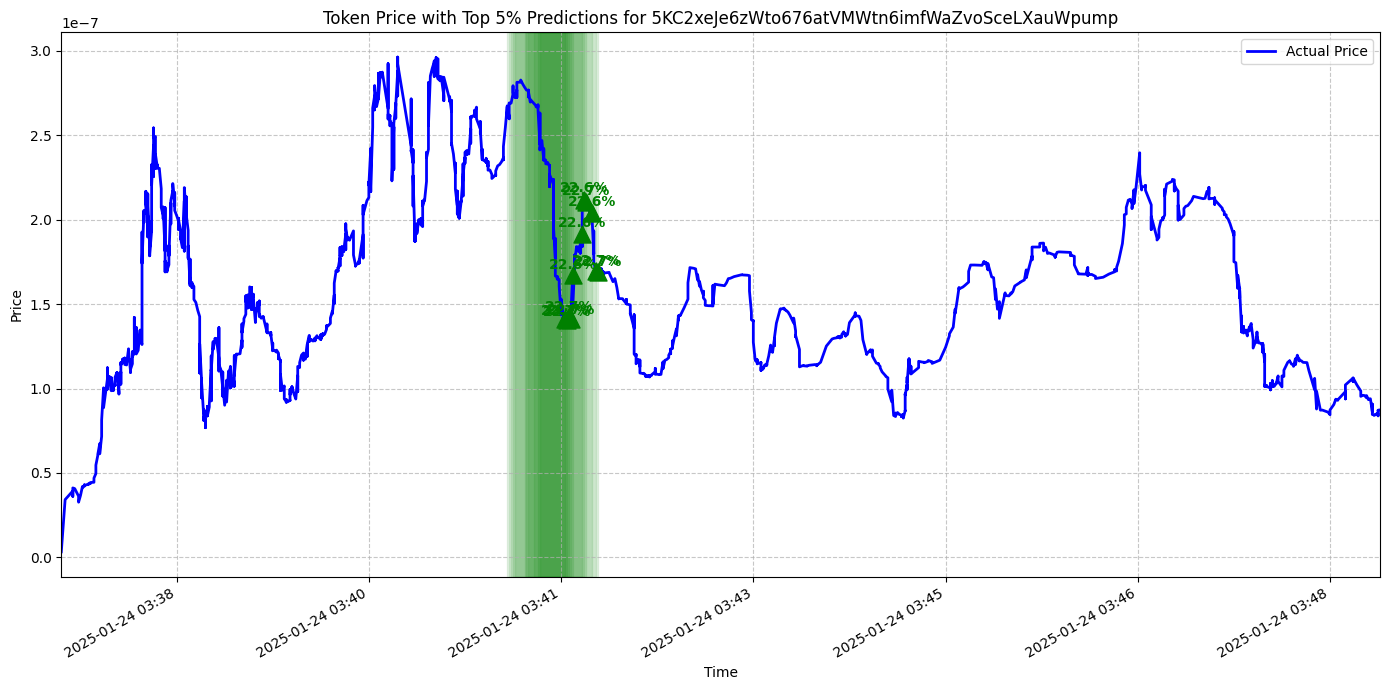

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


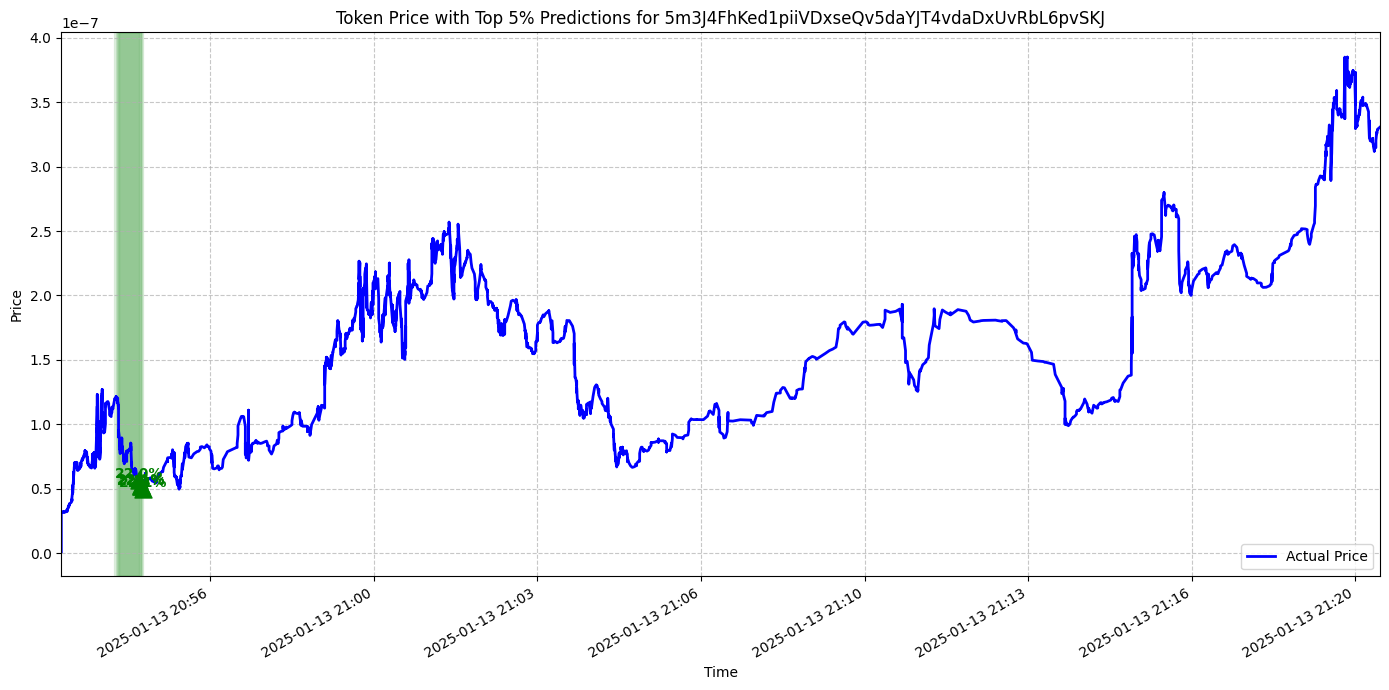

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


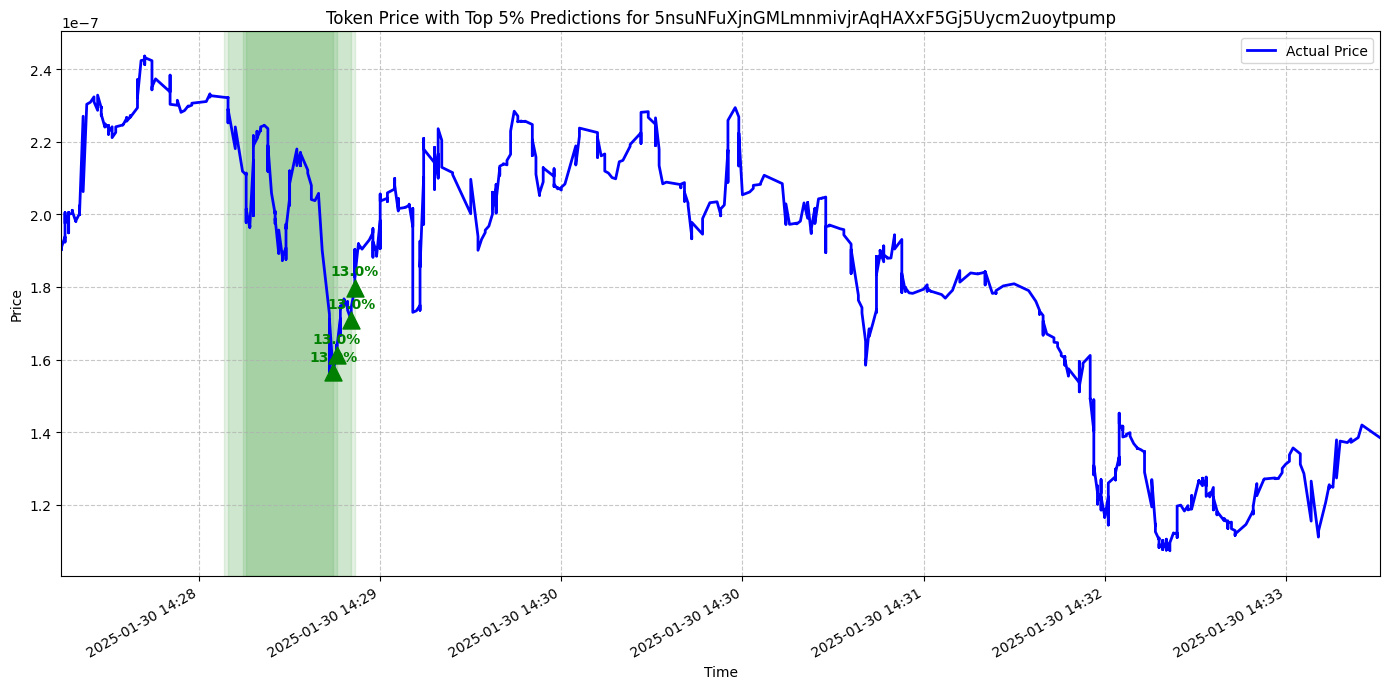

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


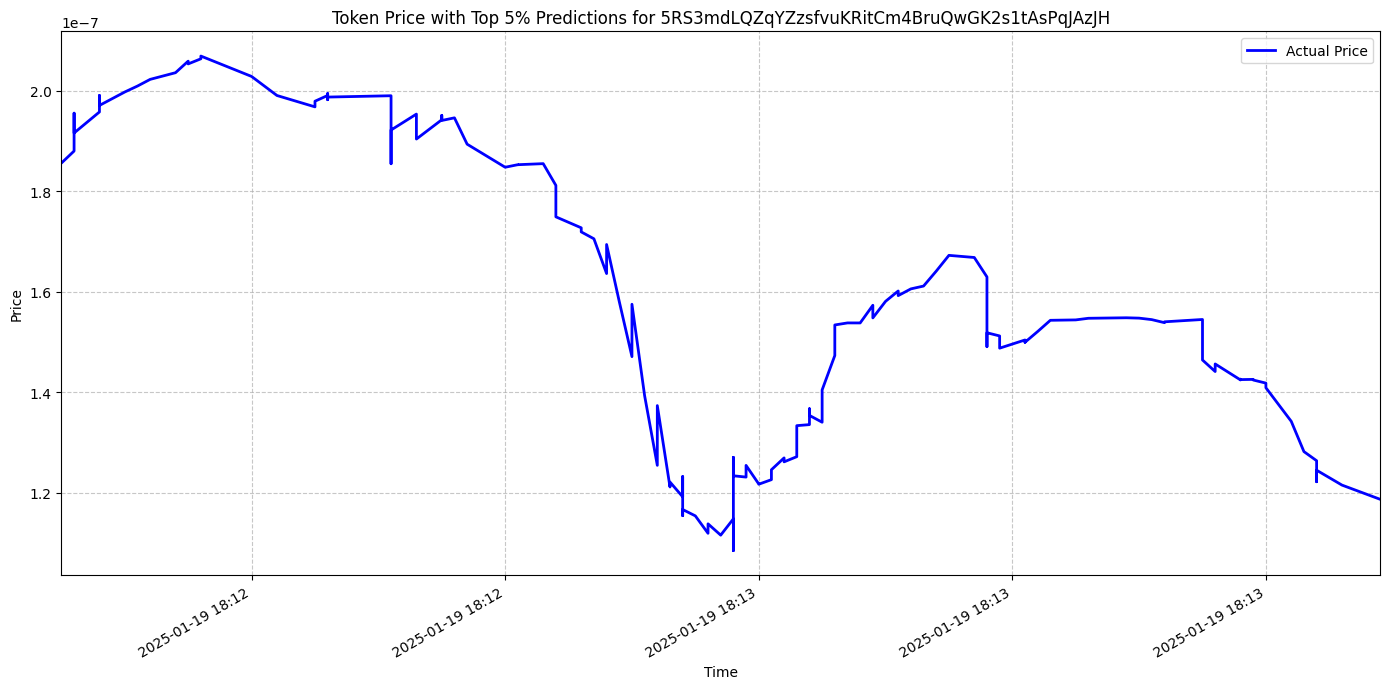

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


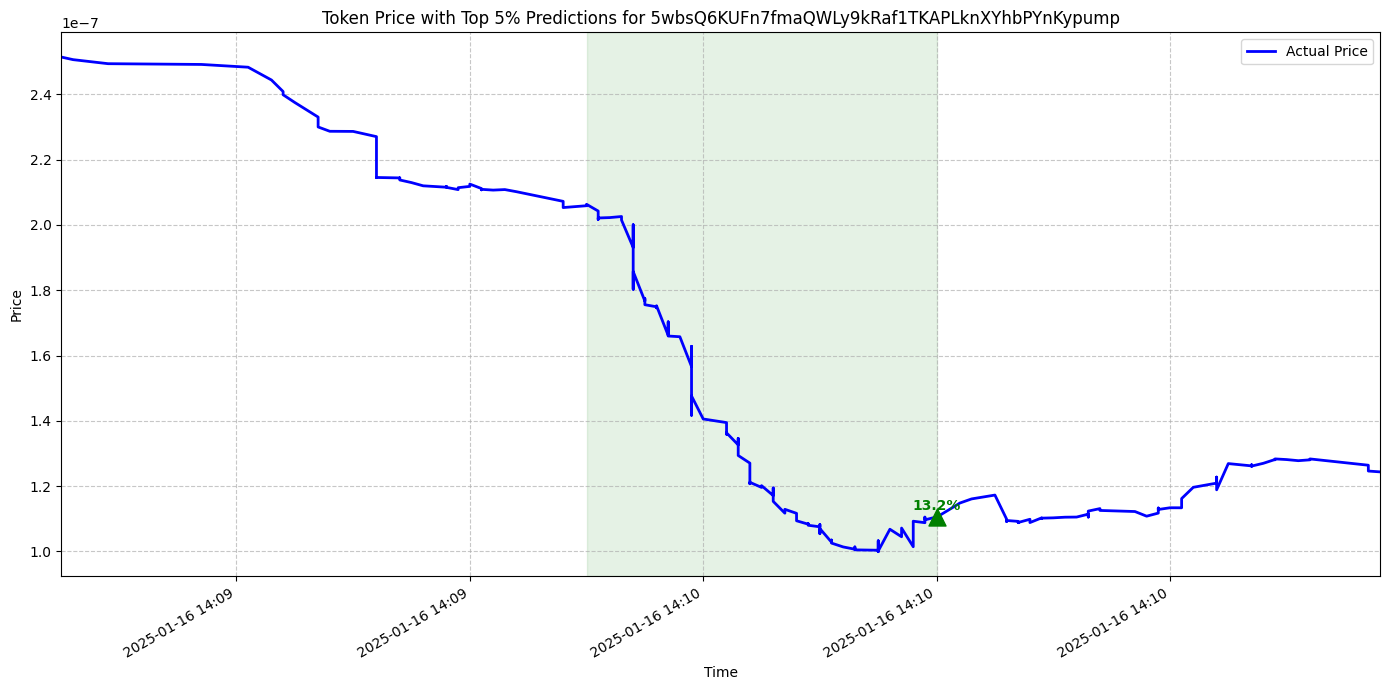

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


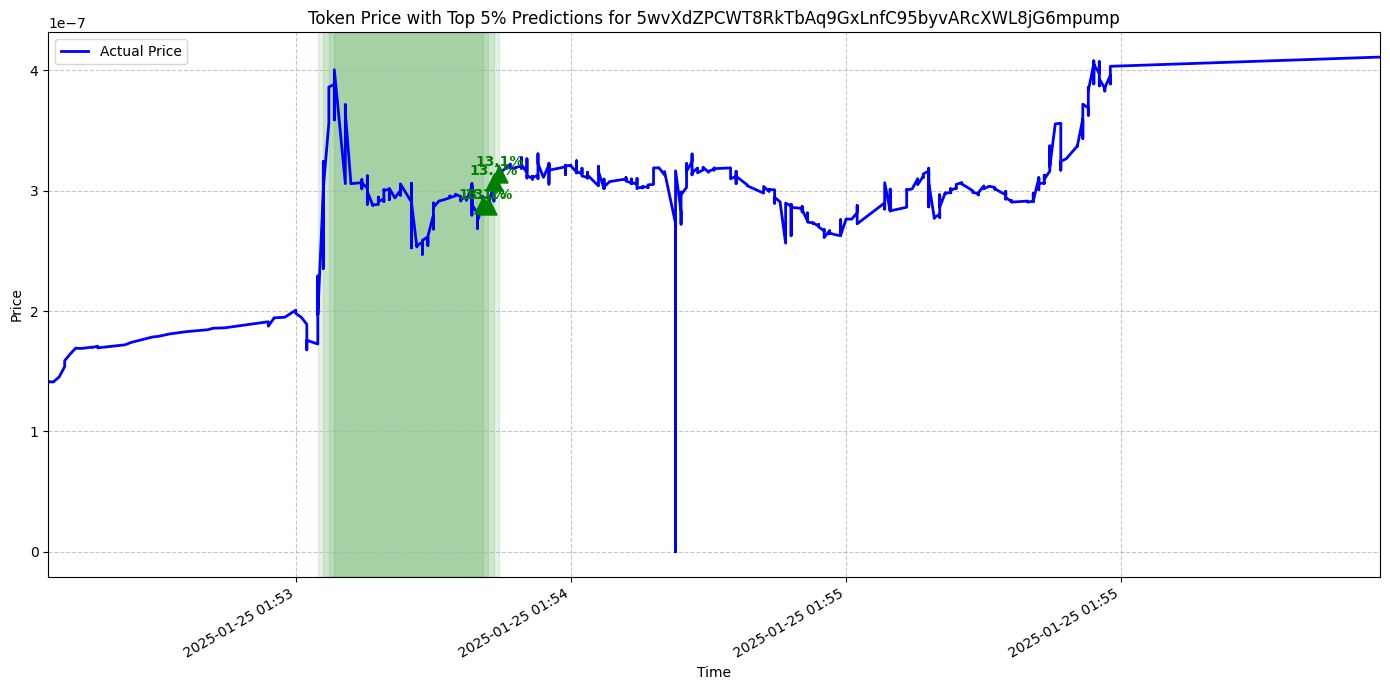

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


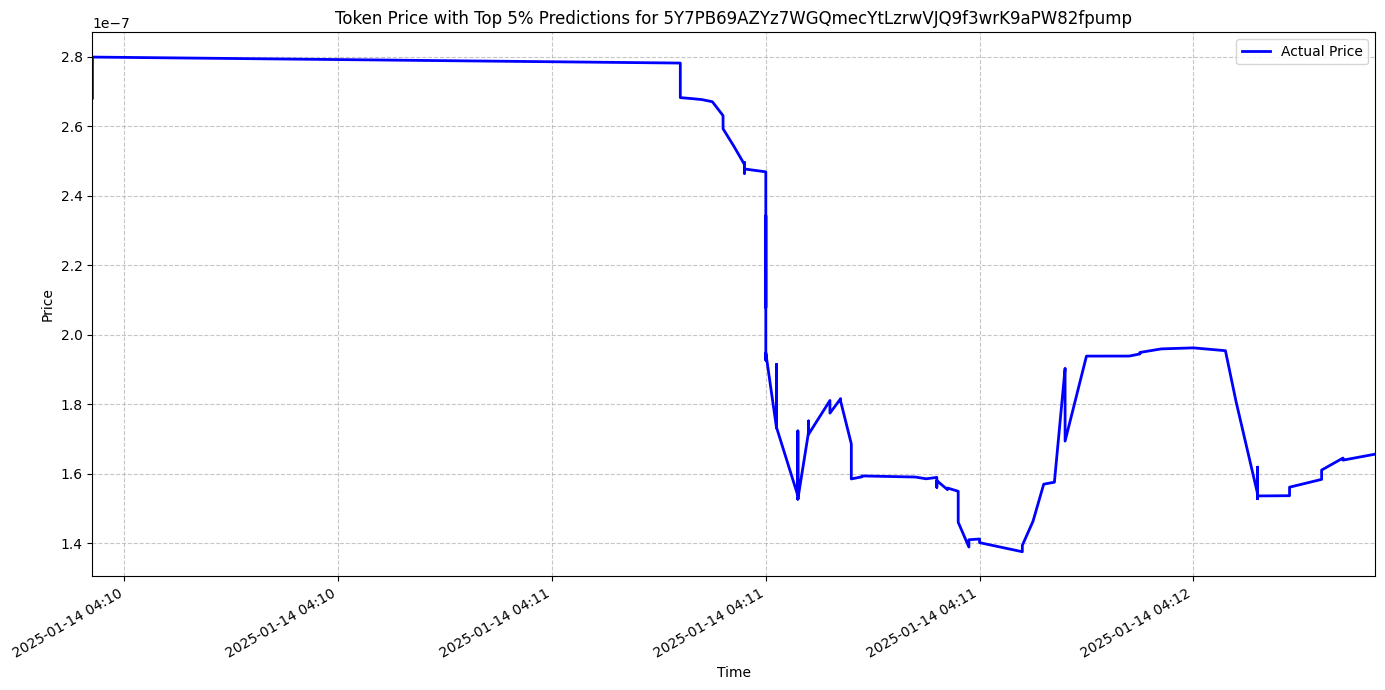

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


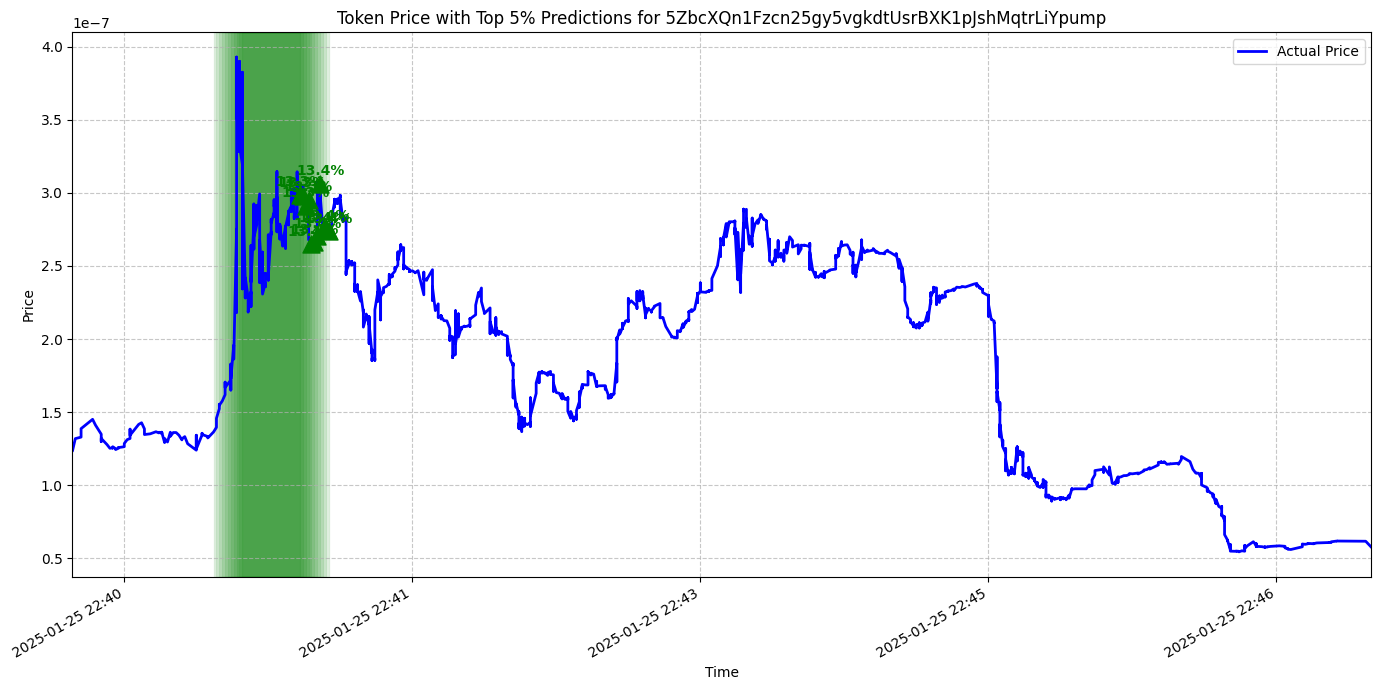

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


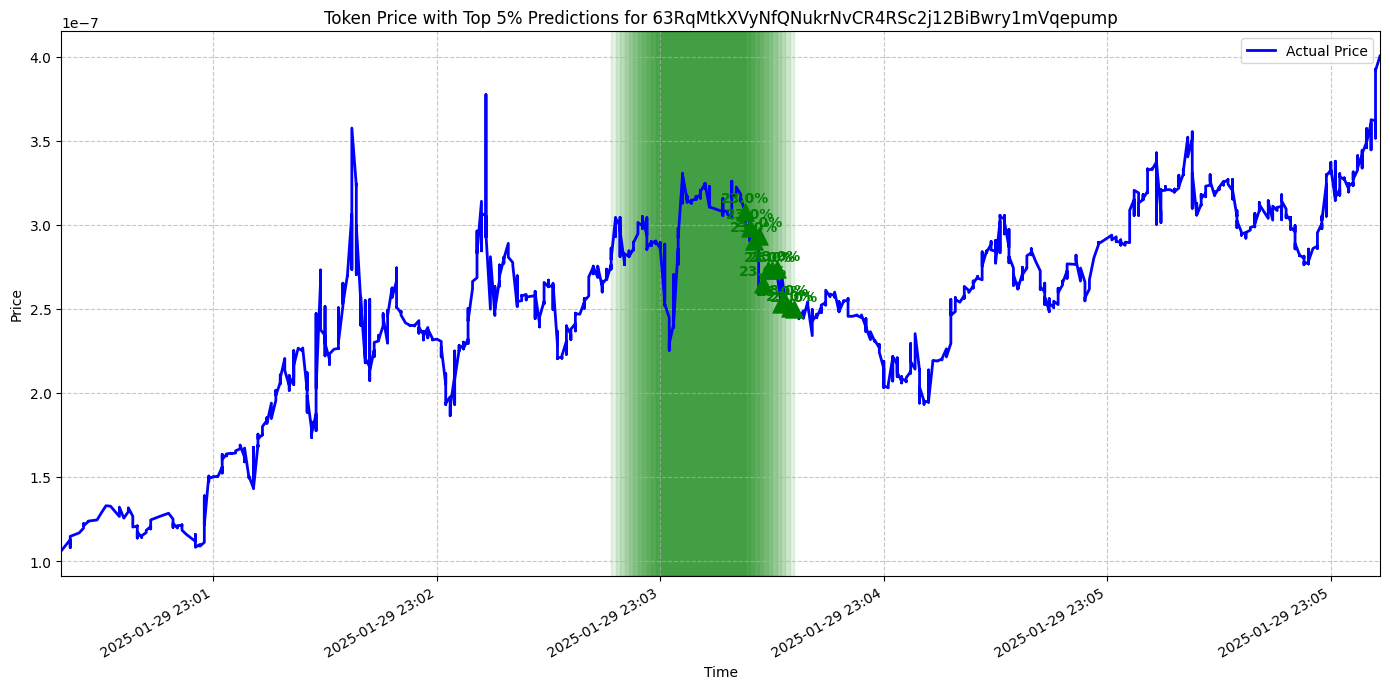

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


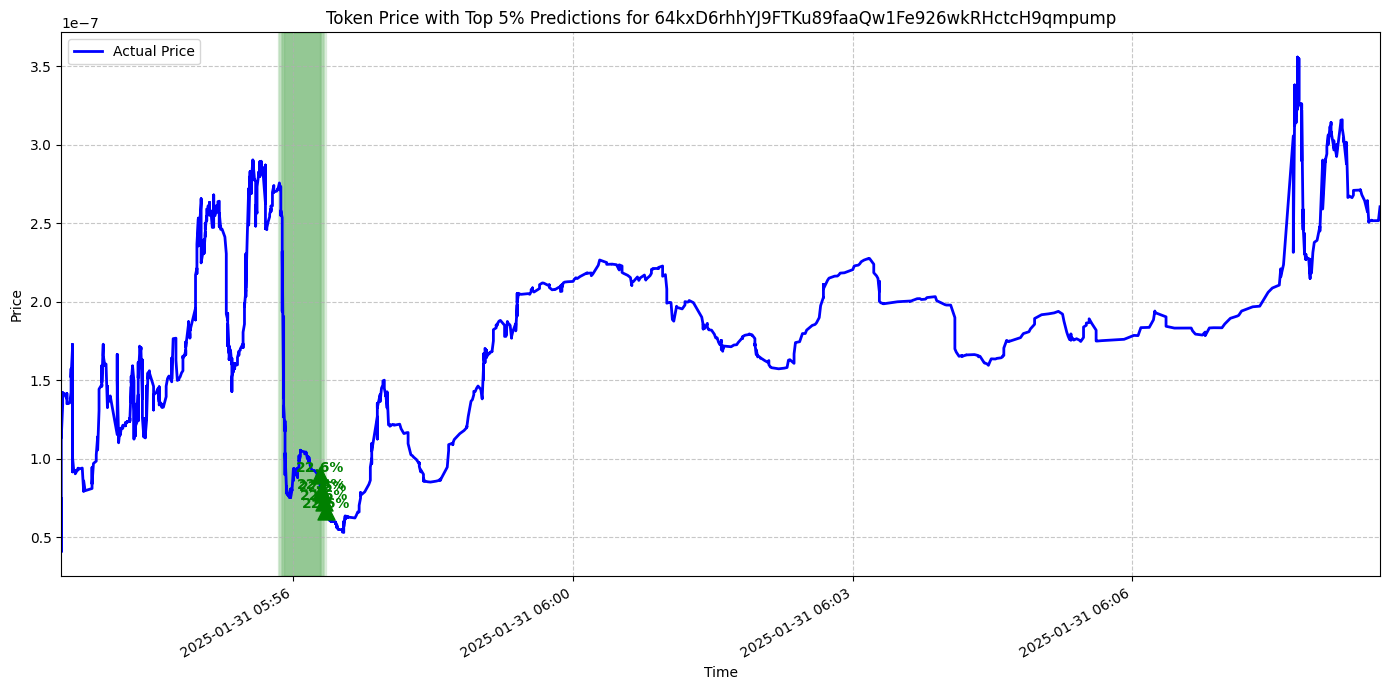

In [5]:
from datetime import datetime
# Plot token price with overlay of the top 5% of predictions
def plot_token_price_with_predictions(token_datasets, model, percentage=5, max_to_plot=4):
    test_tokens = token_datasets[int(len(token_datasets) * test_size): ]
    tokens_to_plot = test_tokens[:min(len(test_tokens), max_to_plot)]
    for X_test, y_test_actual, token_address, bucket_times in tokens_to_plot:
        df = load_token_data(token_address)        
        # Clean data for price plotting
        cleaned_df = remove_price_anomalies(df)
        # Get the actual token prices for the test period
        actual_prices = cleaned_df['token_price']
       
        time_axis = cleaned_df.index
        
        # Calculate the time range to display with padding
        if len(bucket_times) > 0:
            # Find first and last bucket times
            all_starts = [start for start, end in bucket_times]
            all_ends = [end for start, end in bucket_times]
            first_bucket_start = min(all_starts)
            last_bucket_end = max(all_ends)
            
            # Calculate bucket size (assume it's consistent)
            bucket_size = bucket_times[0][1] - bucket_times[0][0]
            
            # Add padding of one bucket size to both sides
            plot_start_time = first_bucket_start - bucket_size
            plot_end_time = last_bucket_end + bucket_size
            
            # Find indices for the time range we want to display
            time_array = np.array(time_axis)
            start_diff = np.abs(time_array - plot_start_time)
            end_diff = np.abs(time_array - plot_end_time)
            plot_start_idx = np.argmin(start_diff)
            plot_end_idx = np.argmin(end_diff)
            
            # Make sure we don't go out of bounds
            plot_start_idx = max(0, plot_start_idx)
            plot_end_idx = min(len(time_axis) - 1, plot_end_idx)
        else:
            # If no buckets, show all data
            plot_start_idx = 0
            plot_end_idx = len(time_axis) - 1
            
        # Create the plot
        plt.figure(figsize=(14, 7))
       
        # Plot the actual price line (only for the time range we care about)
        plt.plot(time_axis[plot_start_idx:plot_end_idx+1], 
                actual_prices.iloc[plot_start_idx:plot_end_idx+1] if hasattr(actual_prices, 'iloc') 
                else actual_prices[plot_start_idx:plot_end_idx+1], 
                label='Actual Price', color='blue', linewidth=2)
        
        y_pred = model.predict(X_test)
        # Inverse transform to get real values
        y_pred_actual = y_scaler.inverse_transform(y_pred)
        y_pred_actual = y_pred_actual.flatten()
        # Find the indices of the top positive and negative predicted changes
        num_to_highlight = int(len(y_pred_actual) * percentage / 100)
        # Sort by absolute value to get largest changes in either direction
        sorted_indices = np.argsort(np.abs(y_pred_actual))[::-1]
        top_indices = sorted_indices[:num_to_highlight]
        
        for index in top_indices:
            prediction = y_pred_actual[index]
            time_bucket = bucket_times[index]
            bucket_start, bucket_end = time_bucket
           
            # Find the closest time point to bucket_end
            time_diff = np.abs(np.array(time_axis) - bucket_end)
            closest_idx = np.argmin(time_diff)
           
            # Get the time point and corresponding price
            closest_time = time_axis[closest_idx]
            y_position = actual_prices.iloc[closest_idx] if hasattr(actual_prices, 'iloc') else actual_prices[closest_idx]
           
            # Determine marker properties based on prediction
            if prediction > 0:
                # Green up triangle for positive prediction
                marker = '^'  # Up triangle
                color = 'green'
            else:
                # Red down triangle for negative prediction
                marker = 'v'  # Down triangle
                color = 'red'
           
            # Add triangle marker
            plt.scatter(closest_time, y_position, color=color, s=150, marker=marker, zorder=5)
           
            # Add text label with prediction percentage
            plt.text(closest_time, y_position * 1.02,
                    f"{prediction*100:.1f}%",
                    color=color, fontweight='bold', ha='center', zorder=5)
        
        # Shade bucket regions
        for index in top_indices:
            bucket_start, bucket_end = bucket_times[index]
            if prediction > 0:
                alpha = 0.1
                color = 'green'
            else:
                alpha = 0.1
                color = 'red'
            plt.axvspan(bucket_start, bucket_end, alpha=alpha, color=color)
       
        # Set title and labels
        plt.title(f'Token Price with Top {percentage}% Predictions for {token_address}')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend(['Actual Price'])
       
        # Add grid for better readability
        plt.grid(True, linestyle='--', alpha=0.7)
       
        # Format x-axis for Unix timestamps
        plt.gca().xaxis.set_major_formatter(
            lambda x, pos: datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M')
            )
        plt.gcf().autofmt_xdate()
        
        # Set x-axis limits
        plt.xlim(time_axis[plot_start_idx], time_axis[plot_end_idx])
       
        plt.tight_layout()
        plt.show()
       
# Call the function to generate plots
plot_token_price_with_predictions(token_datasets, model, max_to_plot=10)